In [1]:
from scipy.stats import kurtosis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
my_random_state = 318
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score,plot_confusion_matrix, confusion_matrix

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.random_projection import GaussianRandomProjection

clusterings = ['k-means','EM']
dimReductions = ['PCA','ICA', 'RP', 'IG']
thisDR = 'PCA'

In [2]:
###### E-coli 
### http://archive.ics.uci.edu/ml/datasets/Ecoli
# data = pd.read_csv('datafiles/ecoli.csv')))  # very unbalanced
# class_names = np.array(['cp', 'im', 'imL', 'imS', 'imU','om','omL','pp'])
data = pd.read_csv('datafiles/ecoli-balance.csv') # balanced: merged sub-species of E-coli
class_names = np.array(['cp', 'im', 'om','pp'])
y_data = data.Y
x_data = data.loc[:,'X1':'X7']

In [3]:
one_hot = OneHotEncoder()

y_data_hot = one_hot.fit_transform(y_data.values.reshape(-1, 1)).todense()
# y_test_hot = le.transform(y_test.reshape(-1, 1)).todense()
y_data_hot.shape

(336, 4)

In [4]:

le = LabelEncoder()
le.fit(y_data.values.tolist())
y_data_le = le.transform(y_data)
y_data_le.shape

(336,)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_le, train_size=0.7, random_state=my_random_state, shuffle=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(235, 7) (101, 7) (235,) (101,)


In [6]:
# le.inverse_transform(y_train)

# 2.1 Dimensionality Reduction: PCA

In [7]:
DR = PCA()

tic = time.perf_counter() 
DR.fit(x_train)
toc = time.perf_counter() 
# train_time[0] = toc-tic
print(f"training time {toc - tic} seconds")
print()

training time 0.007779800000037085 seconds



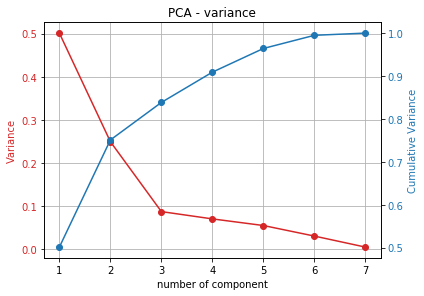

In [53]:
# https://matplotlib.org/gallery/api/two_scales.html

fig, ax1 = plt.subplots()
plt.grid()

color1 = 'tab:red'
ax1.set_xlabel('number of component')
ax1.set_ylabel('Variance', color=color1)
ax1.plot(np.arange(1, DR.explained_variance_ratio_.size + 1), DR.explained_variance_ratio_, marker='o', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:blue'
ax2.set_ylabel('Cumulative Variance', color=color2)  # we already handled the x-label with ax1
ax2.plot(np.arange(1, DR.explained_variance_ratio_.size + 1), np.cumsum(DR.explained_variance_ratio_), marker = 'o', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.title(f'{thisDR} - variance')
plt.savefig(f'part2/{thisDR}_variance.png')
plt.show()

In [9]:
# 4 component is best (beyond elbow & cum var > 0.9)

best_n_components = 4
bestDR = PCA(n_components=best_n_components)
x_train_transform = bestDR.fit_transform(x_train)
x_test_transform = bestDR.fit_transform(x_test)
x_train_inverse = bestDR.inverse_transform(x_train_transform)

# Reconstruction Error
mse = np.sum(np.square(x_train.values - x_train_inverse))/x_train_inverse.size
print('MSE: ', mse)
#  MSE:  0.002285813672259965 for n=4

MSE:  0.008370548519702078


In [ ]:
x_train_transform

In [ ]:
x_train_inverse

# 2.1.1. after dimensional reduction: KMeans

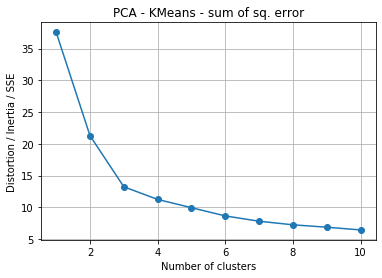

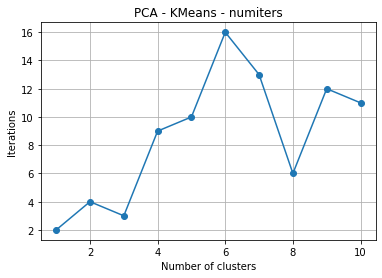

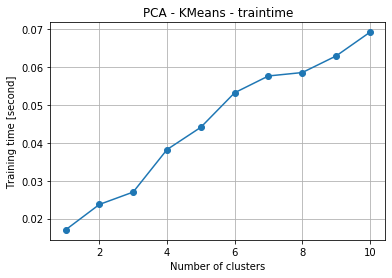

In [10]:
# calculate distortion for a range of number of cluster
distortions = []
numiters = []
traintime = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                random_state=my_random_state)
    
    tic = time.perf_counter() 
    km.fit(x_train_transform)
    toc = time.perf_counter() 
    traintime.append(toc-tic)
    print()
    
    distortions.append(km.inertia_)
    numiters.append(km.n_iter_)

# plot
plt.figure()
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion / Inertia / SSE')
plt.title(f'{thisDR} - KMeans - sum of sq. error')
plt.grid()
plt.savefig(f'part2/{thisDR}_KMeans_distortion.png')
plt.show()


# plot
plt.figure()
plt.plot(range(1, 11), numiters, marker='o')
plt.title(f'{thisDR} - KMeans - numiters')
plt.xlabel('Number of clusters')
plt.ylabel('Iterations')
plt.grid()
plt.savefig(f'part2/{thisDR}_KMeans_numiters.png')
plt.show()


# plot
plt.figure()
plt.plot(range(1, 11), traintime, marker='o')
plt.title(f'{thisDR} - KMeans - traintime')
plt.xlabel('Number of clusters')
plt.ylabel('Training time [second]')
plt.grid()
plt.savefig(f'part2/{thisDR}_KMeans_traintime.png')
plt.show()

## n=4

In [11]:
# the best n_clusters determined to be 4 (same as the original labeling)
km4 = KMeans(n_clusters = 4, random_state = my_random_state)


tic = time.perf_counter() 
km4.fit(x_train_transform)
toc = time.perf_counter() 
# train_time[0] = toc-tic
print(f"training time {toc - tic} seconds")
print()

print(km4.cluster_centers_)
print(km4.labels_)
print(km4.inertia_)
print(km4.n_iter_)

training time 0.03977599999996073 seconds

[[-0.07283984 -0.19392307  0.08866975 -0.02893601]
 [ 0.3888294  -0.06528927 -0.03134522  0.00246724]
 [-0.05548478  0.29453181  0.04533606 -0.01364662]
 [-0.31871943 -0.09622933 -0.05357987  0.02455927]]
[0 3 2 1 1 3 2 2 1 2 3 1 2 2 1 0 0 3 1 3 3 3 3 3 1 3 3 3 0 3 2 1 1 1 2 1 3
 2 2 2 2 2 0 1 1 0 2 0 2 3 0 3 1 1 0 3 1 1 3 3 2 0 1 1 2 3 3 2 2 3 2 3 0 3
 2 1 2 2 3 3 2 0 0 3 3 2 3 3 2 1 0 0 2 3 3 2 1 1 3 3 1 0 1 0 1 0 1 2 0 1 0
 2 0 3 2 1 3 1 2 2 3 1 2 1 3 2 0 1 2 1 2 1 2 0 1 2 1 1 0 1 3 2 3 0 1 1 1 1
 3 1 3 0 3 2 3 3 3 2 1 2 1 0 3 3 1 2 2 3 0 2 3 2 3 2 1 3 1 1 1 2 1 1 0 3 1
 1 2 1 2 3 3 3 3 0 2 3 3 1 1 3 1 2 0 1 3 1 0 0 2 0 2 3 1 1 2 2 1 1 3 0 1 1
 2 1 2 3 1 1 3 3 2 2 1 3 3]
11.258194423375564
9


[[67  0 23  4]
 [ 0 70 10  2]
 [ 0  0  0 17]
 [ 1  1  2 38]]
Prediction accuracy on train set: 0.7446808510638298


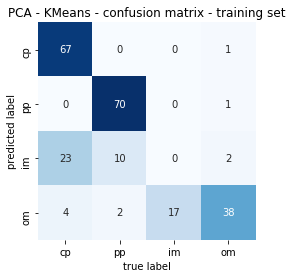

In [14]:
species = ['om','im','pp','cp']
y_train_km4 = []
for l in km4.labels_:
    y_train_km4.append(species[l])


train_confmat_km4 = confusion_matrix(le.inverse_transform(y_train), y_train_km4)
train_accu_km4 = accuracy_score(le.inverse_transform(y_train), y_train_km4)
print(train_confmat_km4)

print(f"Prediction accuracy on train set: {train_accu_km4}")


import seaborn as sns
species.reverse() # for plotting
sns.heatmap(train_confmat_km4.T, cmap=plt.cm.Blues, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species, yticklabels=species)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.title(f'{thisDR} - KMeans - confusion matrix - training set')
plt.savefig(f'part2/{thisDR}_KMeans_confusion_train.png')


In [15]:
# Evaluate quality of clusters
print('training set')
print('Inertia: ', km4.inertia_)
score = silhouette_score(x_train_transform, km4.labels_)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_train).reshape(-1), y_train_km4)
print('Adjusted Mutual Information (AMI) score: ', ami)

training set
Inertia:  11.258194423375564
Silhouette score:  0.3677206149143526
Adjusted Mutual Information (AMI) score:  0.631592350295853


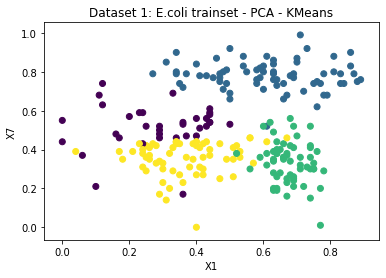

In [16]:
plt.scatter(x_train.X1,x_train.X7, c=km4.labels_, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title(f'Dataset 1: E.coli trainset - {thisDR} - KMeans')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig(f'part2/{thisDR}_KMeans_scatter_train4.png')
plt.show()

testing time 0.0008322000001044216 seconds

[[35  0 11  3]
 [ 0 30  2  2]
 [ 0  0  0  8]
 [ 0  0  0 10]]
Prediction accuracy on test set: 0.7425742574257426


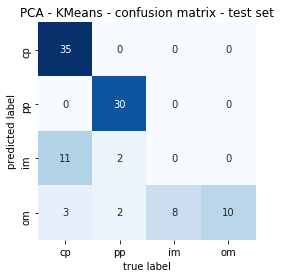

In [17]:


tic = time.perf_counter() 
y_test_predict4 = km4.predict(x_test_transform)
toc = time.perf_counter() 
# test_time[0] = toc-tic
print(f"testing time {toc - tic} seconds")
print()

species = ['om','im','pp','cp']
y_test_km4 = []
for pred in y_test_predict4:
    y_test_km4.append(species[pred])
    
# print(f"Prediction accuracy on test set: {accuracy_score(le.inverse_transform(y_test),y_test_km)}")
# # best_test_accuracy[0] = accuracy_score(y_test,y_test_dt)


test_confmat_km4 = confusion_matrix(le.inverse_transform(y_test), y_test_km4)
test_accu_km4 = accuracy_score(le.inverse_transform(y_test), y_test_km4)
print(test_confmat_km4)
print(f"Prediction accuracy on test set: {test_accu_km4}")


species.reverse() # for plotting
sns.heatmap(test_confmat_km4.T, cmap=plt.cm.Blues, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species, yticklabels=species)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.title(f'{thisDR} - KMeans - confusion matrix - test set')
plt.savefig(f'part2/{thisDR}_KMeans_confusion_test.png')

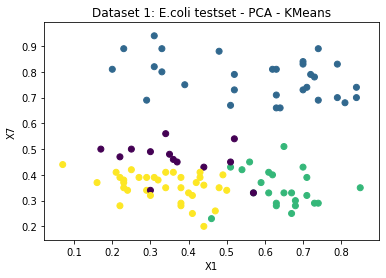

In [18]:
plt.scatter(x_test.X1,x_test.X7, c=y_test_predict4, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title(f'Dataset 1: E.coli testset - {thisDR} - KMeans')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig(f'part2/{thisDR}_KMeans_scatter_test4.png')
plt.show()

In [19]:
# Evaluate quality of clusters
print('test set')
score = silhouette_score(x_test_transform, y_test_predict4)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_test).reshape(-1), y_test_km4)
print('Adjusted Mutual Information (AMI) score: ', ami)

test set
Silhouette score:  0.28939288060568696
Adjusted Mutual Information (AMI) score:  0.6456621553611099


## n=3

In [21]:
# the best n_clusters determined to be 4 (same as the original labeling)
best_n_clusters = 3
km = KMeans(n_clusters = best_n_clusters, random_state = my_random_state)


tic = time.perf_counter() 
km.fit(x_train_transform)
toc = time.perf_counter() 
# train_time[0] = toc-tic
print(f"training time {toc - tic} seconds")
print()

print(km.cluster_centers_)
print(km.labels_)
print(km.inertia_)
print(km.n_iter_)

training time 0.019070499999997992 seconds

[[ 0.37876872 -0.07754253 -0.0247915  -0.00201241]
 [-0.05548478  0.29453181  0.04533606 -0.01364662]
 [-0.24644314 -0.12228293 -0.00930929  0.00981362]]
[2 2 1 0 0 2 1 1 0 1 2 0 1 1 0 0 2 2 0 2 2 2 2 2 0 2 2 2 2 2 1 0 0 0 1 0 2
 1 1 1 1 1 2 0 0 2 1 2 1 2 2 2 0 0 2 2 0 0 2 2 1 2 0 0 1 2 2 1 1 2 1 2 2 2
 1 0 1 1 2 2 1 2 2 2 2 1 2 2 1 0 2 2 1 2 2 1 0 0 2 2 0 2 0 2 0 2 0 1 2 0 0
 1 2 2 1 0 2 0 1 1 2 0 1 0 2 1 2 0 1 0 1 0 1 2 0 1 0 0 2 0 2 1 2 2 0 0 0 0
 2 0 2 2 2 1 2 2 2 1 0 1 0 2 2 2 0 1 1 2 2 1 2 1 2 1 0 2 0 0 0 1 0 0 2 2 0
 0 1 0 1 2 2 2 2 2 1 2 2 0 0 2 0 1 2 0 2 0 2 0 1 2 1 2 0 0 1 1 0 0 2 2 0 0
 1 0 1 2 0 0 2 2 1 1 0 2 2]
13.251074282191034
3


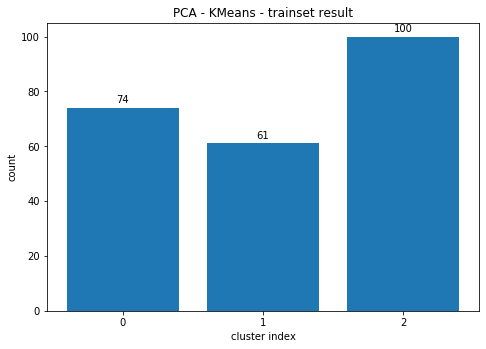

In [22]:
clusterindices = [str(e) for e in range(best_n_clusters)]
counts = np.zeros(best_n_clusters)
for p in km.labels_:
    counts[p] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(clusterindices, counts)
plt.title(f'{thisDR} - KMeans - trainset result')
plt.xlabel('cluster index')
plt.ylabel('count')
plt.savefig(f'part2/{thisDR}_Kmeans_train.png')

def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel2(rects)

plt.show()


In [23]:
# Evaluate quality of clusters
print('training set')
print('Inertia: ', km.inertia_)
score = silhouette_score(x_train_transform, km.labels_)
print('Silhouette score: ', score)
# ami = adjusted_mutual_info_score(le.inverse_transform(y_train).reshape(-1), x_train_km)
ami = adjusted_mutual_info_score(le.inverse_transform(y_train).reshape(-1), km.labels_)
print('Adjusted Mutual Information (AMI) score: ', ami)

training set
Inertia:  13.251074282191034
Silhouette score:  0.4423507627245378
Adjusted Mutual Information (AMI) score:  0.6896651597482492


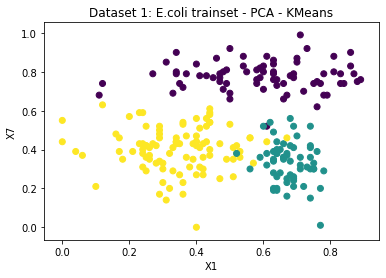

In [24]:
plt.scatter(x_train.X1,x_train.X7, c=km.labels_, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title(f'Dataset 1: E.coli trainset - {thisDR} - KMeans')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig(f'part2/{thisDR}_KMeans_scatter_train.png')
plt.show()

In [25]:


tic = time.perf_counter() 
y_test_predict = km.predict(x_test_transform)
toc = time.perf_counter() 
# test_time[0] = toc-tic
print(f"testing time {toc - tic} seconds")
print()

y_test_predict

testing time 0.0004781000000093627 seconds



array([0, 0, 1, 0, 2, 2, 1, 1, 0, 2, 0, 1, 0, 2, 2, 1, 2, 1, 0, 2, 2, 2,
       2, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2,
       1, 2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2,
       0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 0, 1, 1,
       2, 2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 1, 2])

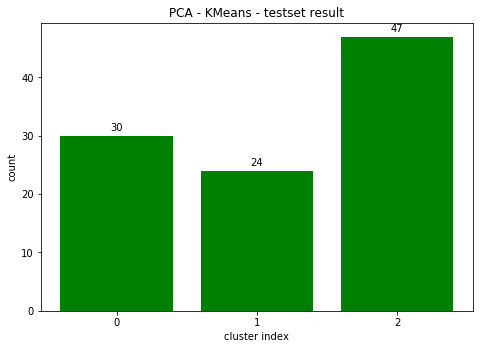

In [26]:
clusterindices = [str(e) for e in range(best_n_clusters)]
counts = np.zeros(best_n_clusters)
for p in y_test_predict:
    counts[p] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(clusterindices, counts, color = 'green')
plt.title(f'{thisDR} - KMeans - testset result')
plt.xlabel('cluster index')
plt.ylabel('count')
plt.savefig(f'part2/{thisDR}_Kmeans_test.png')
def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel2(rects)

plt.show()


In [27]:
# Evaluate quality of clusters
print('test set')
# test_accu_km = accuracy_score(le.inverse_transform(y_test), y_test_gm)
# print(f"Prediction accuracy on test set: {test_accu_gm}")
score = silhouette_score(x_test_transform, y_test_predict)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_test).reshape(-1), y_test_predict)
print('Adjusted Mutual Information (AMI) score: ', ami)

test set
Silhouette score:  0.4246858726841102
Adjusted Mutual Information (AMI) score:  0.719136164200422


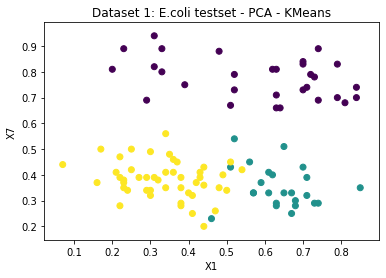

In [28]:
plt.scatter(x_test.X1,x_test.X7, c=y_test_predict, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title(f'Dataset 1: E.coli testset - {thisDR} - KMeans')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig(f'part2/{thisDR}_KMeans_scatter_test.png')
plt.show()

# 2.1.1. after dimensional reduction: Expectation Maximization (EM)

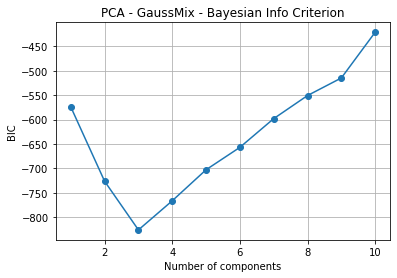

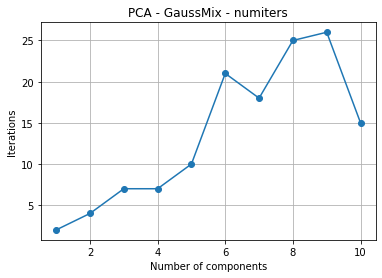

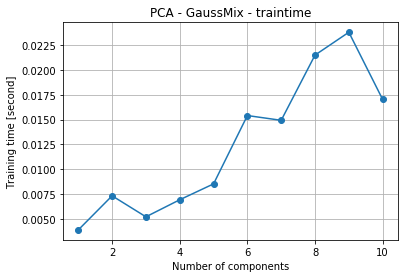

In [29]:
# Find the optimal number of components using BIC
n_components_grid = np.arange(1, 11)
# bic = np.zeros(n_components_grid.size)
bic = []
numiters = []
traintime = []

# for idx, n_components in enumerate(n_components_grid):
for n_components in n_components_grid:
    gm = GaussianMixture(n_components=n_components, random_state=my_random_state)
    
    tic = time.perf_counter() 
    gm.fit(x_train_transform)
    toc = time.perf_counter() 
    traintime.append(toc-tic)
    
    numiters.append(gm.n_iter_)
    bic.append(gm.bic(x_train_transform))
#     bic[idx] = gm.bic(x_train)
print()


# Plot BIC vs number of components
plt.figure()
plt.plot(n_components_grid, bic, marker='o')
# plt.xticks(k_grid)
plt.title(f'{thisDR} - GaussMix - Bayesian Info Criterion')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.grid()
plt.savefig(f'part2/{thisDR}_gm_bic.png')

# plot
plt.figure()
plt.plot(n_components_grid, numiters, marker='o')
plt.title(f'{thisDR} - GaussMix - numiters')
plt.xlabel('Number of components')
plt.ylabel('Iterations')
plt.grid()
plt.savefig(f'part2/{thisDR}_gm_numiters.png')
plt.show()


# plot
plt.figure()
plt.plot(n_components_grid, traintime, marker='o')
plt.title(f'{thisDR} - GaussMix - traintime')
plt.xlabel('Number of components')
plt.ylabel('Training time [second]')
plt.grid()
plt.savefig(f'part2/{thisDR}_gm_traintime.png')
plt.show()

## best_n_component = 4

In [34]:
# the best n_clusters determined to be 4 (same as the original labeling)

best_n_component = 4
gm4 = GaussianMixture(n_components=best_n_component, random_state=my_random_state)


tic = time.perf_counter() 
gm4.fit(x_train_transform)
toc = time.perf_counter() 

print(f"training time {toc - tic} seconds")
print()

y_train_predict4 = gm4.predict(x_train_transform)
y_train_predict4

training time 0.00952019999976983 seconds



array([3, 3, 2, 1, 1, 3, 2, 2, 1, 2, 3, 1, 2, 2, 1, 1, 3, 3, 1, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 0, 3, 2, 1, 1, 1, 2, 1, 3, 2, 2, 2, 2, 2, 0, 1,
       1, 3, 2, 0, 2, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 2, 0, 1, 1, 2, 0,
       3, 2, 2, 3, 2, 3, 0, 3, 2, 1, 2, 2, 3, 3, 2, 0, 0, 0, 3, 2, 3, 3,
       2, 1, 0, 0, 2, 3, 3, 2, 1, 1, 3, 0, 1, 0, 1, 0, 1, 0, 1, 2, 3, 1,
       0, 2, 3, 3, 2, 1, 3, 1, 2, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 2, 1,
       2, 3, 1, 3, 1, 1, 0, 1, 3, 2, 3, 0, 1, 1, 1, 1, 3, 1, 3, 0, 3, 2,
       3, 3, 3, 2, 1, 2, 1, 0, 3, 3, 1, 3, 2, 3, 0, 2, 3, 2, 3, 2, 1, 3,
       1, 1, 1, 2, 1, 1, 0, 3, 1, 1, 2, 1, 2, 3, 3, 3, 3, 0, 2, 3, 3, 1,
       1, 3, 1, 2, 0, 1, 3, 1, 0, 0, 2, 0, 2, 3, 1, 1, 2, 2, 1, 1, 3, 0,
       1, 1, 2, 1, 2, 3, 1, 1, 3, 3, 2, 2, 1, 3, 3], dtype=int64)

[[72  0 19  3]
 [ 1 71  8  2]
 [ 0  0  0 17]
 [ 3  1  1 37]]
Prediction accuracy on train set: 0.7659574468085106


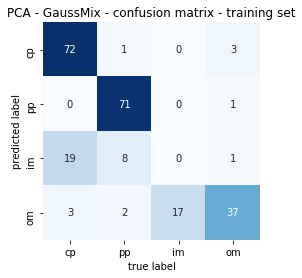

In [35]:
species = ['om','im','pp','cp']
# species = ['pp','om','im','cp']
x_train_gm4 = []
for l in y_train_predict4:
    x_train_gm4.append(species[l])


# train_confmat_gm4 = confusion_matrix(le.inverse_transform(y_train).reshape(-1), np.array(x_train_gm4).reshape(-1))
train_confmat_gm4 = confusion_matrix(le.inverse_transform(y_train), x_train_gm4)
train_accu_gm4 = accuracy_score(le.inverse_transform(y_train), x_train_gm4)
print(train_confmat_gm4)

print(f"Prediction accuracy on train set: {train_accu_gm4}")

species.reverse() # for plotting
sns.heatmap(train_confmat_gm4.T, cmap=plt.cm.Blues, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species, yticklabels=species)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.title(f'{thisDR} - GaussMix - confusion matrix - training set')
plt.savefig(f'part2/{thisDR}_gm_confusion_train.png')


In [36]:
# Evaluate quality of clusters
print('training set')
# print('Inertia: ', km4.inertia_)
score = silhouette_score(x_train_transform, y_train_predict4)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_train).reshape(-1), y_train_predict4)
print('Adjusted Mutual Information (AMI) score: ', ami)

training set
Silhouette score:  0.36491885779527805
Adjusted Mutual Information (AMI) score:  0.6306337056824535


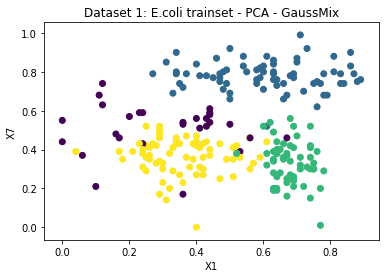

In [37]:
plt.scatter(x_train.X1,x_train.X7, c=y_train_predict4, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title(f'Dataset 1: E.coli trainset - {thisDR} - GaussMix')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig(f'part2/{thisDR}_gm_scatter_train4.png')
plt.show()

In [39]:

tic = time.perf_counter() 
y_test_predict4 = gm4.predict(x_test_transform)
toc = time.perf_counter() 
# test_time[0] = toc-tic
print(f"testing time {toc - tic} seconds")
print()

y_test_predict4

testing time 0.0005943999999544758 seconds



array([1, 1, 2, 1, 3, 0, 2, 2, 1, 0, 1, 2, 1, 3, 3, 3, 3, 2, 1, 0, 0, 3,
       3, 1, 1, 1, 1, 2, 3, 1, 3, 1, 3, 0, 1, 1, 2, 3, 1, 1, 2, 1, 1, 3,
       2, 3, 3, 3, 3, 0, 1, 2, 3, 3, 1, 1, 3, 2, 0, 2, 3, 2, 0, 2, 3, 0,
       1, 3, 0, 2, 1, 3, 3, 3, 3, 3, 3, 2, 3, 0, 1, 3, 0, 0, 3, 1, 2, 0,
       3, 3, 3, 1, 3, 1, 3, 2, 3, 1, 1, 2, 3], dtype=int64)

[[38  0 10  1]
 [ 0 30  3  1]
 [ 0  0  1  7]
 [ 0  0  0 10]]
Prediction accuracy on test set: 0.7821782178217822


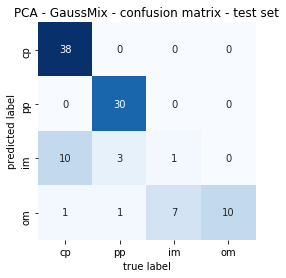

In [40]:


species = ['om','im','pp','cp']
y_test_gm4 = []
for pred in y_test_predict4:
    y_test_gm4.append(species[pred])
    
# print(f"Prediction accuracy on test set: {accuracy_score(le.inverse_transform(y_test),y_test_km)}")
# # best_test_accuracy[0] = accuracy_score(y_test,y_test_dt)


test_confmat_gm4 = confusion_matrix(le.inverse_transform(y_test), y_test_gm4)
test_accu_gm4 = accuracy_score(le.inverse_transform(y_test), y_test_gm4)
print(test_confmat_gm4)
print(f"Prediction accuracy on test set: {test_accu_gm4}")


species.reverse() # for plotting
sns.heatmap(test_confmat_gm4.T, cmap=plt.cm.Blues, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species, yticklabels=species)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.title(f'{thisDR} - GaussMix - confusion matrix - test set')
plt.savefig(f'part2/{thisDR}_gm_confusion_test.png')

In [41]:
# Evaluate quality of clusters
print('test set')
# test_accu_km = accuracy_score(le.inverse_transform(y_test), y_test_gm)
# print(f"Prediction accuracy on test set: {test_accu_gm}")
score = silhouette_score(x_test_transform, y_test_predict)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_test).reshape(-1), y_test_predict)
print('Adjusted Mutual Information (AMI) score: ', ami)

test set
Silhouette score:  0.3001649763130457
Adjusted Mutual Information (AMI) score:  0.6776755487299876


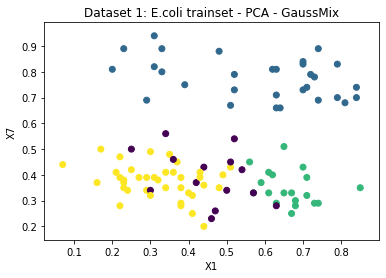

In [42]:
plt.scatter(x_test.X1,x_test.X7, c=y_test_predict4, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title(f'Dataset 1: E.coli trainset - {thisDR} - GaussMix')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig(f'part2/{thisDR}_gm_scatter_test4.png')
plt.show()

# best_n_component = 3

In [43]:
# 3 is determined to be the best number of components
best_n_component = 3
gm = GaussianMixture(n_components=best_n_component, random_state=my_random_state)


tic = time.perf_counter() 
gm.fit(x_train_transform)
toc = time.perf_counter() 

print(f"training time {toc - tic} seconds")
print()

y_train_predict = gm.predict(x_train_transform)
y_train_predict

training time 0.00890479999998206 seconds



array([0, 0, 2, 1, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 1, 0, 2, 2, 2, 2, 2, 0, 1,
       1, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 2,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0,
       2, 1, 0, 0, 2, 0, 0, 2, 1, 1, 0, 2, 1, 0, 1, 1, 1, 0, 1, 2, 0, 1,
       1, 2, 0, 0, 2, 1, 0, 1, 2, 2, 0, 1, 2, 1, 0, 2, 0, 1, 2, 1, 2, 1,
       2, 0, 1, 2, 1, 1, 0, 1, 0, 2, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 2,
       0, 0, 0, 2, 1, 2, 1, 1, 0, 0, 1, 2, 2, 0, 0, 2, 0, 2, 0, 2, 1, 0,
       1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1,
       1, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 0, 2, 0, 1, 1, 2, 2, 1, 1, 0, 0,
       1, 1, 2, 1, 2, 0, 1, 1, 0, 0, 2, 2, 1, 0, 0], dtype=int64)

In [44]:
# Evaluate quality of clusters
print('training set')
score = silhouette_score(x_train_transform, y_train_predict)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_train).reshape(-1), y_train_predict)
print('Adjusted Mutual Information (AMI) score: ', ami)
# print(f"Prediction accuracy on train set: {accuracy_score(le.inverse_transform(y_train),y_train_predict)}")

training set
Silhouette score:  0.4338877454425382
Adjusted Mutual Information (AMI) score:  0.6634055112419815


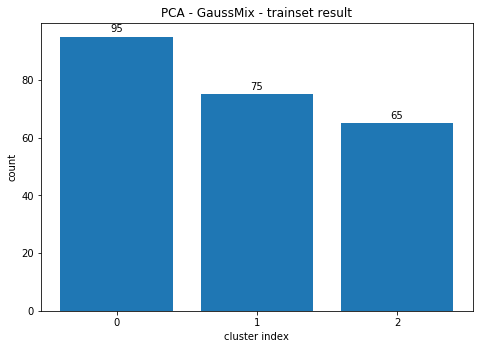

In [45]:
clusterindices = [str(e) for e in range(best_n_component)]
counts = np.zeros(best_n_component)
for yp in y_train_predict:
    counts[yp] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(clusterindices,counts)

def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel2(rects)

plt.title(f'{thisDR} - GaussMix - trainset result')
plt.xlabel('cluster index')
plt.ylabel('count')
plt.savefig(f'part2/{thisDR}_gm_train.png')
plt.show()

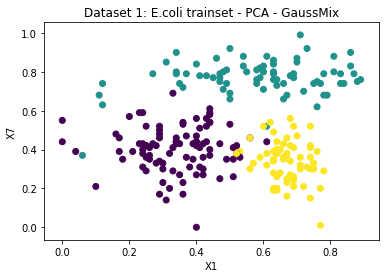

In [46]:
plt.scatter(x_train.X1,x_train.X7, c=y_train_predict, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title(f'Dataset 1: E.coli trainset - {thisDR} - GaussMix')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig(f'part2/{thisDR}_gm_scatter_train.png')
plt.show()

In [49]:


tic = time.perf_counter() 
y_test_predict = gm.predict(x_test_transform)
toc = time.perf_counter() 
# test_time[0] = toc-tic
print(f"testing time {toc - tic} seconds")
print()

y_test_predict

testing time 0.0005879000000277301 seconds



array([1, 1, 2, 1, 0, 0, 2, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0,
       2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0,
       1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0,
       0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 1, 2, 0], dtype=int64)

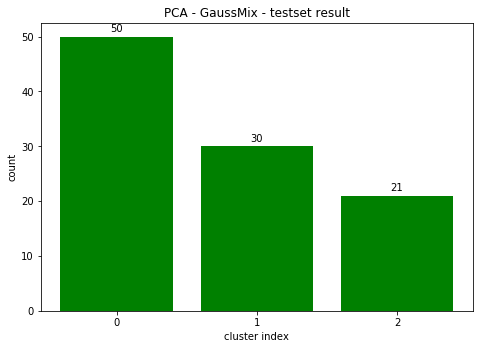

In [50]:
clusterindices = [str(e) for e in range(best_n_component)]
counts = np.zeros(best_n_component)
for p in y_test_predict:
    counts[p] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(clusterindices, counts, color = 'green')
plt.title(f'{thisDR} - GaussMix - testset result')
plt.xlabel('cluster index')
plt.ylabel('count')
plt.savefig(f'part2/{thisDR}_gm_test.png')
def autolabel2(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel2(rects)

plt.show()


In [51]:
# Evaluate quality of clusters
print('test set')
# test_accu_km = accuracy_score(le.inverse_transform(y_test), y_test_gm)
# print(f"Prediction accuracy on test set: {test_accu_gm}")
score = silhouette_score(x_test_transform, y_test_predict)
print('Silhouette score: ', score)
ami = adjusted_mutual_info_score(le.inverse_transform(y_test).reshape(-1), y_test_predict)
print('Adjusted Mutual Information (AMI) score: ', ami)

test set
Silhouette score:  0.4314539514160839
Adjusted Mutual Information (AMI) score:  0.7602900752758687


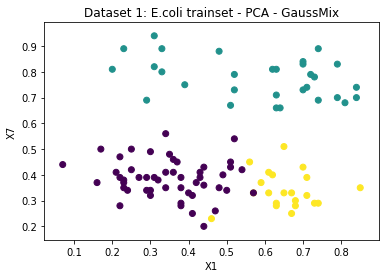

In [52]:
plt.scatter(x_test.X1,x_test.X7, c=y_test_predict, cmap='viridis')
# plt.colorbar();  # show color scale
plt.title(f'Dataset 1: E.coli trainset - {thisDR} - GaussMix')
plt.xlabel('X1')
plt.ylabel('X7')
plt.savefig(f'part2/{thisDR}_gm_scatter_test.png')
plt.show()

# 没用的

In [ ]:
species = ['om','pp','im','cp']
y_train_gm = []
for l in y_train_predict:
    y_train_gm.append(species[l])


train_confmat_gm = confusion_matrix(le.inverse_transform(y_train), y_train_gm)
train_accu_gm = accuracy_score(le.inverse_transform(y_train), y_train_gm)
print(train_confmat_gm)

print(f"Prediction accuracy on train set: {train_accu_gm}")


species.reverse() # for plotting
sns.heatmap(train_confmat_gm.T, cmap=plt.cm.Blues, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=species, yticklabels=species)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.title('initial clustering - GaussMix - confusion matrix - training set')
plt.savefig('part1/initial_gm_confusion_train.png')


In [ ]:

# plot
plt.figure()
plt.hist(y_train_predict, bins = best_n_component)
plt.title('initial clustering - GaussMix - result')
plt.xlabel('cluster #')
plt.ylabel('count')
# plt.grid()
plt.savefig('part1/initial_gm_result.png')
plt.show()



In [ ]:

plt.figure()
plt.hist(km3.labels_, bins=np.arange(0, best_n_clusters + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, best_n_clusters))
plt.xlabel('Cluster label')
plt.ylabel('Number of samples')
plt.grid()
plt.title('PCA - KMeans - train set')
plt.savefig('part2/PCA_Kmeans_train.png')